# Take a double image

After we saw [how a single image](./take_a_single_image.ipynb) is taken, we can create the second one.

In [1]:
import numpy as np

import synpivimage as spi 
spi.__version__

'1.0.0'

In [2]:
from synpivimage import take_image, Camera, Laser, Particles

In [3]:
cam = Camera(
    nx=16,
    ny=16,
    bit_depth=16,
    qe=1,
    sensitivity=1,
    baseline_noise=50,
    dark_noise=10,
    shot_noise=False,
    fill_ratio_x=1.0,
    fill_ratio_y=1.0,
    particle_image_diameter=2  # px
)

laser = Laser(
    width=0.25,
    shape_factor=2
)

In [4]:
ppp = 0.1
n = int(ppp * (5+cam.nx*cam.ny))  # +5 so that images can move into image B

particles = Particles(
    x=np.random.uniform(-1, cam.nx-1, n),
    y=np.random.uniform(0, cam.ny-1, n),
    z=np.zeros(n),
    size=np.ones(n)*2,
)

In [5]:
imgA, partA = take_image(laser, cam, particles, particle_peak_count=1000)

imgB, partB = take_image(laser, cam,
                         partA.displace(dx=4, dz=laser.width/2),
                         particle_peak_count=1000)


In [6]:
dpart = partB-partA

(<Axes: >, <Axes: >, <Axes: >, <Axes: >)

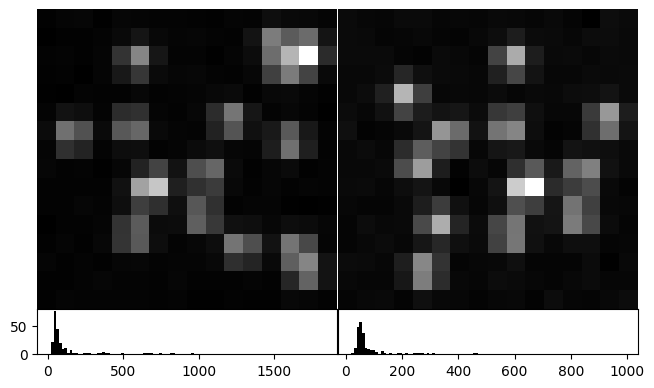

In [7]:
imgAB = imgA.pair_with(imgB)
imgAB.plot()

In [8]:
partA.info()

=== Particle Information === 
 > Number of simulated particles: 26
 > Number of active (illuminated and in FOV) particles: 17
 > Number of particles outside of FOV: 9
 > Out of plane particles: 0


In [9]:
partA.source_density_number, partA.source_density_number / cam.size

(17, 0.06640625)

In [10]:
partB.source_density_number, partB.source_density_number / cam.size

(13, 0.05078125)

In [11]:
partB.info()

=== Particle Information === 
 > Number of simulated particles: 26
 > Number of active (illuminated and in FOV) particles: 13
 > Number of particles outside of FOV: 13
 > Out of plane particles: 0


This means, that we lost the following percentage of particles out of plane:

In [12]:
partB.n_out_of_plane_loss/partA.n_active*100

0.0

## Save double images

We can save both images individually as done with a single image:

In [13]:
from synpivimage.io import Imwriter

In [17]:
with Imwriter(case_name='double_img', camera=cam, laser=laser, overwrite=True) as iw:
    iw.writeA(imgA, partA)
    iw.writeB(imgB, partB)

Preparing the folder
writing A image
writing B image
Done
